In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2




import pandas as pd
import io
import boto3
from boto3.dynamodb.conditions import Key
import os
from google_images_download import google_images_download
import glob
import PIL
import json
import numpy as np
import pathlib
import pickle

import textacy
import en_core_web_sm


#import code

In [2]:
cwd = os.getcwd()
os.path.join(cwd, 'get_model_training_data')

'/home/ec2-user/environment/AttnGAN/get_model_training_data'

# Get Text Data for inputTerm

## Inputs

In [3]:
inputTerm = 'photosynthesis'
topic ='biology'


tblName = "ResourceDocuments"
nodeIdentifierName = "photosynthesis-photosynthesis-photosynthesis-biology"

termTxtToImage_flpth = 'data/photosynthesis'
text_flpth = os.path.join(termTxtToImage_flpth, 'text')
img_flpth =  os.path.join(termTxtToImage_flpth, 'images')
imageLog_fir='logs'

resourceDbName = 'dynamodb'
#s3Bucket = "egm-bucket/TEXT_TO_IMAGE_DATA/data"

### Get Data from Resource Db: 
photosynthesis whole

In [4]:
# Get Definitions for photosynthesis from dynamodb

## Connect to dynamodb
dynamodbClient = boto3.resource("dynamodb")
# client = boto3.client('dynamodb')
# display(client.describe_table(TableName=tblName))

## Connect to table with resources
resourceTbl = dynamodbClient.Table(tblName)
# display(resourceTbl.global_secondary_indexes)
display("NUmber of Items in ResourceDb: {}".format(resourceTbl.item_count))

'NUmber of Items in ResourceDb: 14'

### Load text into pandas 
- For data munging
    - stats
    - Duplicates

In [5]:
response = resourceTbl.query(
    IndexName='NODE_IDENTIFIER-index',
    KeyConditionExpression=Key('NODE_IDENTIFIER').eq(nodeIdentifierName)
)

# Pass through pandas for some data munging
rsrc_df = pd.DataFrame(response["Items"])
print("Db Response Shape: {}".format(rsrc_df.shape))

rsrc_df.drop_duplicates(['RESOURCE'], keep='last', inplace=True)
rsrc_df.reset_index(drop=True)

print("Db Response Shape: {}".format(rsrc_df.shape))
print(rsrc_df.columns)

Db Response Shape: (14, 13)
Db Response Shape: (7, 13)
Index(['IMAGES', 'NODE_IDENTIFIER', 'POS', 'RESOURCE', 'RESOURCE_ATTRIBUTION',
       'RESOURCE_DATATYPE', 'RESOURCE_SOURCE', 'RESOURCE_TYPE', 'RESOURCE_URL',
       'TERM', 'TIME_DOWNLOADED', 'TOPIC', 'UNIQUE_IDENTIFIER'],
      dtype='object')


In [8]:
rsrc_df["RESOURCE_SOURCE"]

4        century
5        wordnet
9     wiktionary
10     wikipedia
11         gcide
12     wikipedia
13    ahd-legacy
Name: RESOURCE_SOURCE, dtype: object

### Load text from s3 to df

### Ingest corpus data from df

In [8]:
def df_to_corpus(df):
    # Load into textacy to delimit sentences
    img_labels = df.to_dict(orient="records")
    text_stream, metadata_stream = textacy.io.split_records(img_labels, 'RESOURCE')

    # Load english model
    en = en_core_web_sm.load()
    corpus = textacy.Corpus(lang=en, texts=text_stream, metadatas=metadata_stream)
    
    return corpus

In [10]:
captionsCorpus = df_to_corpus(rsrc_df)
captionsCorpus.docs

[Doc(37 tokens; "A chemical combination brought about by the act..."),
 Doc(14 tokens; "synthesis of compounds with the aid of radiant ..."),
 Doc(24 tokens; "The process by which plants and other photoauto..."),
 Doc(512 tokens; "Photosynthesis is a process used by plants and ..."),
 Doc(200 tokens; "The process of constructive metabolism by which..."),
 Doc(140 tokens; "Photosynthesis is a process used by plants and ..."),
 Doc(36 tokens; "The process in green plants and certain other o...")]

### Split data into captions

In [ ]:
def transformText_to_captions(txtDoc, numCaptions_per_image=5, txtSplit_method='svo'):
    # Take textacy doc and converts to a list of captions for an image
    
    if txtSplit_method=='noun_chunks':
        split_list = list(textacy.extract.noun_chunks(txtDoc, drop_determiners=False, min_freq=1))
    if txtSplit_method=='svo':
        split_list = list(textacy.extract.subject_verb_object_triples(txtDoc))
    
    return split_list

In [29]:
# 1  Find the document with the min number of tokens
minToken_num = min([doc.n_tokens for doc in captionsCorpus])
print(f"Shortest Doc number of tokens {minToken_num}")

shortestDocs = captionsCorpus.get(lambda x: len(x)==minToken_num)
shortestDoc = list(shortestDocs)[0]
# 2  Find the maximum amount of captions that can be made for the shortest doc



Shortest Doc number of tokens 14


In [30]:
shortestDoc
    

Doc(14 tokens; "synthesis of compounds with the aid of radiant ...")

### 2. Make captions for images

In [25]:
list(textacy.extract.noun_chunks(txtDoc, drop_determiners=False, min_freq=1))

AttributeError: 'list' object has no attribute 'noun_chunks'

In [ ]:
txtDoc = imgTxt_corpus[0]
txtDoc

In [ ]:
imgTxt_corpus


In [ ]:
imgTxt_corpus.get(lambda x: len(x)

In [ ]:
docSplit_list = transformText_to_captions(txtDoc, numCaptions_per_image=5, txtSplit_method='svo')

In [ ]:
list(textacy.extract.ngrams(txtDoc, n=5, filter_stops=False))

In [ ]:
txtDoc.text

In [ ]:
textacy.extract.acronyms_and_definitions(txtDoc)

In [15]:
minToken_num

14

In [16]:
list(shortestDoc)

[Doc(14 tokens; "synthesis of compounds with the aid of radiant ...")]

In [153]:
for i in k:
    print(i)

Doc(14 tokens; "synthesis of compounds with the aid of radiant ...")


### Create Labels for text to image model

In [ ]:
def handle_missing_directories(directory_flpth):
    # Handle missing Directory
    if not os.path.exists(directory_flpth):
        
        os.makedirs(directory_flpth)
        print("Made new directory: {}".format(directory_flpth))
        # print(os.path.join(dirname, flpth))
    else:
        pass
    
    return

# Create text file for each doc - Each Doc maps to an image

## TODO: incoroporate number of labals per line
def labels_to_imageTxt_files(rsrc_df, trainingData_term, trainigData_flpth='../data'):
    
    # Handle if a data directory for a term exists e.g. data/photosynthesis
    dirname = os.path.abspath('')
    termData_flpth = os.path.join(dirname, trainigData_flpth)
    handle_missing_directories(termData_flpth)
    
    
    ### Move resource df to textacy
   
    # Load into textacy to delimit sentences
    img_labels = rsrc_df.to_dict(orient="records")
    text_stream, metadata_stream = textacy.io.split_records(img_labels, 'RESOURCE')

    # Load english model
    en = en_core_web_sm.load()
    labels_corpus = textacy.Corpus(lang=en, texts=text_stream, metadatas=metadata_stream)
    
    caption_filename_path = os.path.join(trainigData_flpth, "captions.pickle")
    
    # Loop through corpus and write document to flpth (s3)
    ''' Each doc in a corpus equals and image'''
    for ix, doc in enumerate(labels_corpus):
        print("Number of Sentences: {}".format(doc.n_sents))
        
        # Paths to directories (Where to write the text files)
        filename = "{}_{}.txt".format(trainingData_term, ix)
        path_to_file = "{}/{}".format(trainigData_flpth, filename)
        
        # Write captions for google images
        f =  open(path_to_file, 'w')
        
        # Parse Document into sentences
        for sent in doc.sents:
            caption = textacy.preprocess.preprocess_text(sent.text,
                                               lowercase=True,
                                               no_punct=True
                                              )
            # f.write(label+"\n" )
            f.write(caption+" " )
            
        f.close()
        
    return ix + 1 # Count using 1 as start

# process labels for images


trainingData_term = 'photosynthesis'
txt_trainingData_flpth='{}/text'.format(termTxtToImage_flpth, 'text')

numText_files = labels_to_imageTxt_files(rsrc_df, trainingData_term, txt_trainingData_flpth)
numText_files

### Download Images from google 

In [91]:

def download_images(term ,img_args):
    
    # Download Images 
    response = google_images_download.googleimagesdownload()
    img_paths = response.download(img_args)
    
    # Post Process google image results
    for idx, f in enumerate(img_paths[term]):
        
        # Open Google image resulst and conver to jpeg
        img = PIL.Image.open(f)
        img_filetype = img.format.lower()  # 'JPEG'
        
        rgb_img = img.convert('RGB')
        img.close()
        
        # Make new filenme to allign with text file name
        filename = "{}_{}.{}".format(trainingData_term, idx, 'jpg')
        newfilepath_f = os.path.join(os.path.dirname(f), filename)
        
        # Save and image
        rgb_img.save(newfilepath_f)
        os.remove(f)
    
    
    return response 

img_args = {"keywords":"sun",
             "format": "png",
              "limit": 20,
             "output_directory": 'data',
            "metadata": True,
            "image_directory": "photosynthesis/images",
            "no_download": False,
            "extract_metadata":True
            # "size":"icon"
           }

response = download_images(trainingData_term, img_args)

NameError: name 'trainingData_term' is not defined

### 1. Inputs

In [ ]:
#import tigDataLoader.utiils as dataloader
import os
import json
import logging

In [ ]:
predictTerm = "photosynthesis"
dataTerm = "photosynthesis"

In [ ]:
# Base file io inputs
trainData_flpth = os.path.join('data', predictTerm)
text_flpth = os.path.join(trainData_flpth, 'text')
img_flpth =  os.path.join(trainData_flpth, 'images')

# Google imagae download metadata
imageLog_fir='logs'

In [ ]:
def transformText_to_captions(txtDoc, numCaptions_per_image=5, txtSplit_method='svo'):
    # Take textacy doc and converts to a list of captions for an image
    
    if txtSplit_method=='noun_chunks':
        split_list = list(textacy.extract.noun_chunks(txtDoc, drop_determiners=False, min_freq=1))
    if txtSplit_method=='svo':
        split_list = list(textacy.extract.subject_verb_object_triples(txtDoc))
    
    return split_list

### 3. Download images
- from google

In [ ]:
img_args = {"keywords": dataTerm,
             "format": "png",
              "limit": 100,
             "output_directory": 'data',
            "metadata": True,
            "image_directory": "{}/images/".format(predictTerm),
            "no_download": False,
            "extract_metadata":True,
            "type": "clipart"
           }
img_paths, response = dataloader.download_images(dataTerm, img_args)

In [ ]:
# Download text from 

In [ ]:
## load text into textacy
imgTxt_corpus = df_to_corpus()


In [ ]:
list(labels_corpus.docs[0].sents)

In [ ]:
import requests
r = requests.get("https://ssec.si.edu/stemvisions-blog/what-photosynthesis")

In [ ]:
r.content

In [ ]:
# Create Fake data
import shutil
import itertools

# Get a list of the original files f
txtDirFileNm_lst = glob.glob(text_flpth+"/**/*.txt", recursive=True)
imgDirFileNm_lst = glob.glob(img_flpth+"/**/*.jpg", recursive=True)

fileCombo_lst = list(itertools.product(txtDirFileNm_lst,imgDirFileNm_lst))

# for item in fileCombo_lst:
    
#     # Get text name
#     txtget_relfilename

# # # Create list paired tuple pairs
# # comboFlpth_lst = list(zip(txtDirFileNm_lst, imgDirFileNm_lst))
# # comboFlpth_lst

# # new_list = []
# # for k,v in comboFlpth_lst.iteritems():
# #     new_list.extend([x for x in combinations(v, 2)]) 
# # # for txtFile, imgFile in comboFlpth_dict:
# # #     # Make copies of files and rename
# # #     shutil.copyfile(txtFile, dst)
# # #     shutil.copyfile(imgFile, dst)

# # new_list



In [163]:
import seaborn as sns
df = pd.read_csv("RUNS.csv")
df.shape

(6, 18)

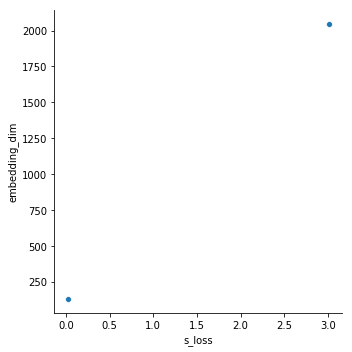

In [164]:
sns.relplot(x="s_loss", y="embedding_dim", data=df);